In [ ]:
# TODO vector arithmetic
# TODO print intermediate images while training

In [65]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from time import time

In [2]:
dev=torch.device('cpu')
if torch.cuda.is_available: dev=torch.device('cuda')
dev

device(type='cuda')

In [146]:
ds=datasets.MNIST('data',download=True,train=True,transform=T.ToTensor())

Layer width in generator is reversed compared to common convnet. This seems logical, since here we start w/ pretty small information, so we "boost" it in the 1st layer using maximum channels. Also num of channels has to gradually drop towards the end since the final layer is an normal image, so wider layers are placed at the beginning of network.

Sigmoid instead of paper's tanh worked equally well for mnist.

In [142]:
def getgen():
    return nn.Sequential(
        nn.ConvTranspose2d(100,256,4,bias=False) #4
        ,nn.BatchNorm2d(256),nn.ReLU()
        ,nn.ConvTranspose2d(256,128,3,stride=2,padding=1,bias=False) #7
        ,nn.BatchNorm2d(128),nn.ReLU()
        ,nn.ConvTranspose2d(128,64,4,stride=2,padding=1,bias=False) #14
        ,nn.BatchNorm2d(64),nn.ReLU()
        ,nn.ConvTranspose2d(64,1,4,stride=2,padding=1,bias=False) #28
        ,nn.Sigmoid()
    ).to(dev)

Tried ReLU instead of LeakyReLU for 1 training session of 3 epochs. It seemed like leaky variant is indeed better.

In [159]:
class Squeeze(nn.Module):
    def forward(self,x): return x.squeeze()

def getdiscr():
    return nn.Sequential(
        nn.Conv2d(1,64,4,stride=2,padding=1,bias=False) #14
        ,nn.LeakyReLU(.2)
        ,nn.Conv2d(64,128,4,stride=2,padding=1,bias=False) #7
        ,nn.BatchNorm2d(128),nn.LeakyReLU(.2)
        ,nn.Conv2d(128,256,4,stride=2,padding=1,bias=False) #3
        ,nn.BatchNorm2d(256),nn.LeakyReLU(.2)
        ,nn.Conv2d(256,1,3,bias=False) #1
        ,Squeeze()
        ,nn.Sigmoid()
    ).to(dev)

In [183]:
epochs=3
gen_lr=2e-4
discr_lr=5e-4
betas=(.5,.999)
bs=100
n_noise=100 # num of input noise pixels

dl=data.DataLoader(ds,batch_size=bs,shuffle=True)
gen=getgen()
discr=getdiscr()
gen_opt=optim.Adam(gen.parameters(),lr=gen_lr,betas=betas)
discr_opt=optim.Adam(discr.parameters(),lr=discr_lr,betas=betas)
losses={'dloss_real':[],'dloss_fake':[],'gloss':[]}

In [184]:
t0=time()
for ep in range(epochs):
    for i,(xb,yb) in enumerate(dl):
        discr_opt.zero_grad()
        xb=xb.to(dev)
        yb=torch.empty(yb.shape,device=dev).uniform_(.8,1.) # label smoothing
        dloss_real=F.binary_cross_entropy(discr(xb),yb)
        dloss_real.backward()
        losses['dloss_real'].append(dloss_real.item())
        
        zb=torch.randn(xb.shape[0],n_noise,1,1,device=dev)
        gb=gen(zb)
        yb=torch.zeros_like(yb)
        # note: gen images are detached, so no gen grads are calculated
        dloss_fake=F.binary_cross_entropy(discr(gb.detach()),yb)
        dloss_fake.backward()
        losses['dloss_fake'].append(dloss_fake.item())
        discr_opt.step()
        
        gen_opt.zero_grad()
        yb=torch.ones_like(yb)
        gloss=F.binary_cross_entropy(discr(gb),yb)
        gloss.backward()
        losses['gloss'].append(gloss.item())
        gen_opt.step()
        
        print('[%2d/%2d][%3d/%3d] dloss_real=%.4f dloss_fake=%.4f gloss=%.4f'%
              (ep+1,epochs,i+1,len(dl),dloss_real,dloss_fake,gloss))
        if (i+1)%100==0: print('elapsed time',time()-t0,'s')

print('total time',time()-t0,'s')

[ 1/ 3][  1/600] dloss_real=0.6565 dloss_fake=0.7375 gloss=3.5732
[ 1/ 3][  2/600] dloss_real=0.3754 dloss_fake=0.0839 gloss=4.7442
[ 1/ 3][  3/600] dloss_real=0.3550 dloss_fake=0.0260 gloss=5.1656
[ 1/ 3][  4/600] dloss_real=0.3540 dloss_fake=0.0130 gloss=5.2413
[ 1/ 3][  5/600] dloss_real=0.3497 dloss_fake=0.0112 gloss=5.0374
[ 1/ 3][  6/600] dloss_real=0.3678 dloss_fake=0.0185 gloss=5.1782
[ 1/ 3][  7/600] dloss_real=0.3653 dloss_fake=0.0137 gloss=5.1927
[ 1/ 3][  8/600] dloss_real=0.3490 dloss_fake=0.0145 gloss=5.4399
[ 1/ 3][  9/600] dloss_real=0.3329 dloss_fake=0.0102 gloss=4.9361
[ 1/ 3][ 10/600] dloss_real=0.3437 dloss_fake=0.0208 gloss=6.1418
[ 1/ 3][ 11/600] dloss_real=0.3274 dloss_fake=0.0044 gloss=6.1783
[ 1/ 3][ 12/600] dloss_real=0.3364 dloss_fake=0.0042 gloss=6.1284
[ 1/ 3][ 13/600] dloss_real=0.3038 dloss_fake=0.0043 gloss=5.4911
[ 1/ 3][ 14/600] dloss_real=0.3557 dloss_fake=0.0085 gloss=6.3840
[ 1/ 3][ 15/600] dloss_real=0.3695 dloss_fake=0.0032 gloss=4.7370
[ 1/ 3][ 1

[ 1/ 3][125/600] dloss_real=0.3271 dloss_fake=0.0027 gloss=6.1468
[ 1/ 3][126/600] dloss_real=0.3393 dloss_fake=0.0022 gloss=6.0233
[ 1/ 3][127/600] dloss_real=0.3238 dloss_fake=0.0029 gloss=5.9784
[ 1/ 3][128/600] dloss_real=0.3217 dloss_fake=0.0028 gloss=6.1137
[ 1/ 3][129/600] dloss_real=0.3234 dloss_fake=0.0025 gloss=5.9677
[ 1/ 3][130/600] dloss_real=0.3282 dloss_fake=0.0028 gloss=6.0466
[ 1/ 3][131/600] dloss_real=0.3568 dloss_fake=0.0026 gloss=6.1647
[ 1/ 3][132/600] dloss_real=0.3337 dloss_fake=0.0022 gloss=6.1363
[ 1/ 3][133/600] dloss_real=0.3401 dloss_fake=0.0025 gloss=6.0331
[ 1/ 3][134/600] dloss_real=0.3359 dloss_fake=0.0028 gloss=6.0449
[ 1/ 3][135/600] dloss_real=0.3177 dloss_fake=0.0025 gloss=6.1335
[ 1/ 3][136/600] dloss_real=0.3288 dloss_fake=0.0026 gloss=6.0058
[ 1/ 3][137/600] dloss_real=0.3397 dloss_fake=0.0029 gloss=5.9760
[ 1/ 3][138/600] dloss_real=0.3198 dloss_fake=0.0027 gloss=5.8556
[ 1/ 3][139/600] dloss_real=0.3523 dloss_fake=0.0033 gloss=6.0625
[ 1/ 3][14

[ 1/ 3][249/600] dloss_real=0.8998 dloss_fake=0.1273 gloss=1.2486
[ 1/ 3][250/600] dloss_real=0.3680 dloss_fake=1.1475 gloss=5.3105
[ 1/ 3][251/600] dloss_real=1.7297 dloss_fake=0.0362 gloss=2.3981
[ 1/ 3][252/600] dloss_real=0.4371 dloss_fake=0.3232 gloss=1.9008
[ 1/ 3][253/600] dloss_real=0.3880 dloss_fake=0.6377 gloss=3.0060
[ 1/ 3][254/600] dloss_real=0.6617 dloss_fake=0.1696 gloss=2.3894
[ 1/ 3][255/600] dloss_real=0.5631 dloss_fake=0.2953 gloss=1.9097
[ 1/ 3][256/600] dloss_real=0.5255 dloss_fake=0.3521 gloss=2.4490
[ 1/ 3][257/600] dloss_real=0.5368 dloss_fake=0.2818 gloss=2.6810
[ 1/ 3][258/600] dloss_real=0.5964 dloss_fake=0.2338 gloss=2.0865
[ 1/ 3][259/600] dloss_real=0.5258 dloss_fake=0.4055 gloss=2.6758
[ 1/ 3][260/600] dloss_real=0.6007 dloss_fake=0.2549 gloss=2.3183
[ 1/ 3][261/600] dloss_real=0.4980 dloss_fake=0.2825 gloss=2.5910
[ 1/ 3][262/600] dloss_real=0.5504 dloss_fake=0.2185 gloss=2.4180
[ 1/ 3][263/600] dloss_real=0.4252 dloss_fake=0.2551 gloss=2.8189
[ 1/ 3][26

[ 1/ 3][373/600] dloss_real=0.4631 dloss_fake=0.0954 gloss=2.6153
[ 1/ 3][374/600] dloss_real=0.4530 dloss_fake=0.1442 gloss=2.3791
[ 1/ 3][375/600] dloss_real=0.3954 dloss_fake=0.1807 gloss=2.9624
[ 1/ 3][376/600] dloss_real=0.6265 dloss_fake=0.1212 gloss=1.3964
[ 1/ 3][377/600] dloss_real=0.3700 dloss_fake=0.4990 gloss=4.4132
[ 1/ 3][378/600] dloss_real=0.9045 dloss_fake=0.0382 gloss=1.7064
[ 1/ 3][379/600] dloss_real=0.3613 dloss_fake=0.3003 gloss=2.5102
[ 1/ 3][380/600] dloss_real=0.3778 dloss_fake=0.1992 gloss=3.2402
[ 1/ 3][381/600] dloss_real=0.5635 dloss_fake=0.1007 gloss=2.0322
[ 1/ 3][382/600] dloss_real=0.3873 dloss_fake=0.3005 gloss=2.9315
[ 1/ 3][383/600] dloss_real=0.5342 dloss_fake=0.1405 gloss=2.3044
[ 1/ 3][384/600] dloss_real=0.4045 dloss_fake=0.1548 gloss=2.5643
[ 1/ 3][385/600] dloss_real=0.3968 dloss_fake=0.1891 gloss=3.0650
[ 1/ 3][386/600] dloss_real=0.5510 dloss_fake=0.1045 gloss=1.7238
[ 1/ 3][387/600] dloss_real=0.3676 dloss_fake=0.3507 gloss=3.9912
[ 1/ 3][38

[ 1/ 3][497/600] dloss_real=0.4305 dloss_fake=0.4105 gloss=2.4263
[ 1/ 3][498/600] dloss_real=0.4714 dloss_fake=0.1602 gloss=2.3936
[ 1/ 3][499/600] dloss_real=0.4542 dloss_fake=0.1753 gloss=2.3467
[ 1/ 3][500/600] dloss_real=0.4195 dloss_fake=0.1831 gloss=2.3781
elapsed time 205.51898646354675 s
[ 1/ 3][501/600] dloss_real=0.4871 dloss_fake=0.1896 gloss=2.2776
[ 1/ 3][502/600] dloss_real=0.4391 dloss_fake=0.1683 gloss=2.2320
[ 1/ 3][503/600] dloss_real=0.3996 dloss_fake=0.2228 gloss=2.9476
[ 1/ 3][504/600] dloss_real=0.4919 dloss_fake=0.0906 gloss=1.9175
[ 1/ 3][505/600] dloss_real=0.3769 dloss_fake=0.2044 gloss=2.9992
[ 1/ 3][506/600] dloss_real=0.4863 dloss_fake=0.1447 gloss=2.3080
[ 1/ 3][507/600] dloss_real=0.4193 dloss_fake=0.1650 gloss=2.7327
[ 1/ 3][508/600] dloss_real=0.4932 dloss_fake=0.1280 gloss=1.7588
[ 1/ 3][509/600] dloss_real=0.3927 dloss_fake=0.3612 gloss=3.7964
[ 1/ 3][510/600] dloss_real=0.8881 dloss_fake=0.0478 gloss=0.7961
[ 1/ 3][511/600] dloss_real=0.3493 dloss_f

[ 2/ 3][ 21/600] dloss_real=0.4798 dloss_fake=0.2241 gloss=2.0391
[ 2/ 3][ 22/600] dloss_real=0.4116 dloss_fake=0.2876 gloss=2.4572
[ 2/ 3][ 23/600] dloss_real=0.5585 dloss_fake=0.1768 gloss=1.8414
[ 2/ 3][ 24/600] dloss_real=0.3996 dloss_fake=0.2836 gloss=2.5424
[ 2/ 3][ 25/600] dloss_real=0.5144 dloss_fake=0.1493 gloss=1.8951
[ 2/ 3][ 26/600] dloss_real=0.4118 dloss_fake=0.3019 gloss=2.8110
[ 2/ 3][ 27/600] dloss_real=0.6912 dloss_fake=0.1486 gloss=1.3301
[ 2/ 3][ 28/600] dloss_real=0.3564 dloss_fake=0.4133 gloss=3.6425
[ 2/ 3][ 29/600] dloss_real=0.7513 dloss_fake=0.0633 gloss=1.7465
[ 2/ 3][ 30/600] dloss_real=0.4072 dloss_fake=0.4437 gloss=2.6612
[ 2/ 3][ 31/600] dloss_real=0.5350 dloss_fake=0.1315 gloss=2.2518
[ 2/ 3][ 32/600] dloss_real=0.4692 dloss_fake=0.2215 gloss=2.1926
[ 2/ 3][ 33/600] dloss_real=0.4793 dloss_fake=0.2222 gloss=2.2444
[ 2/ 3][ 34/600] dloss_real=0.4566 dloss_fake=0.2170 gloss=2.2815
[ 2/ 3][ 35/600] dloss_real=0.4097 dloss_fake=0.1425 gloss=2.4527
[ 2/ 3][ 3

[ 2/ 3][145/600] dloss_real=0.4642 dloss_fake=0.3498 gloss=2.4197
[ 2/ 3][146/600] dloss_real=0.6450 dloss_fake=0.2021 gloss=1.5967
[ 2/ 3][147/600] dloss_real=0.4618 dloss_fake=0.3212 gloss=1.8964
[ 2/ 3][148/600] dloss_real=0.5224 dloss_fake=0.3285 gloss=2.0301
[ 2/ 3][149/600] dloss_real=0.5130 dloss_fake=0.1730 gloss=1.9448
[ 2/ 3][150/600] dloss_real=0.4393 dloss_fake=0.2647 gloss=2.2511
[ 2/ 3][151/600] dloss_real=0.4242 dloss_fake=0.2235 gloss=2.5166
[ 2/ 3][152/600] dloss_real=0.6341 dloss_fake=0.1926 gloss=1.3064
[ 2/ 3][153/600] dloss_real=0.3653 dloss_fake=0.4330 gloss=2.8860
[ 2/ 3][154/600] dloss_real=0.6167 dloss_fake=0.0904 gloss=1.9311
[ 2/ 3][155/600] dloss_real=0.3982 dloss_fake=0.3212 gloss=2.3299
[ 2/ 3][156/600] dloss_real=0.5407 dloss_fake=0.2327 gloss=1.8550
[ 2/ 3][157/600] dloss_real=0.4223 dloss_fake=0.3110 gloss=2.6232
[ 2/ 3][158/600] dloss_real=0.5978 dloss_fake=0.1137 gloss=1.6874
[ 2/ 3][159/600] dloss_real=0.4154 dloss_fake=0.4657 gloss=2.9556
[ 2/ 3][16

[ 2/ 3][269/600] dloss_real=0.5670 dloss_fake=0.1429 gloss=1.9095
[ 2/ 3][270/600] dloss_real=0.4365 dloss_fake=0.3342 gloss=2.7451
[ 2/ 3][271/600] dloss_real=0.6580 dloss_fake=0.1195 gloss=1.4755
[ 2/ 3][272/600] dloss_real=0.3952 dloss_fake=0.5556 gloss=3.5280
[ 2/ 3][273/600] dloss_real=0.9515 dloss_fake=0.0488 gloss=1.3108
[ 2/ 3][274/600] dloss_real=0.3896 dloss_fake=0.6209 gloss=2.7531
[ 2/ 3][275/600] dloss_real=0.7306 dloss_fake=0.1375 gloss=1.7721
[ 2/ 3][276/600] dloss_real=0.4491 dloss_fake=0.3397 gloss=1.9171
[ 2/ 3][277/600] dloss_real=0.4696 dloss_fake=0.3159 gloss=2.7561
[ 2/ 3][278/600] dloss_real=0.8261 dloss_fake=0.1286 gloss=0.9812
[ 2/ 3][279/600] dloss_real=0.3822 dloss_fake=0.7267 gloss=3.5391
[ 2/ 3][280/600] dloss_real=0.9772 dloss_fake=0.0971 gloss=1.4140
[ 2/ 3][281/600] dloss_real=0.4512 dloss_fake=0.3433 gloss=1.9983
[ 2/ 3][282/600] dloss_real=0.4709 dloss_fake=0.2414 gloss=2.4790
[ 2/ 3][283/600] dloss_real=0.6246 dloss_fake=0.1679 gloss=1.5762
[ 2/ 3][28

[ 2/ 3][393/600] dloss_real=0.4083 dloss_fake=0.4657 gloss=2.7410
[ 2/ 3][394/600] dloss_real=0.5829 dloss_fake=0.1737 gloss=2.2390
[ 2/ 3][395/600] dloss_real=0.5447 dloss_fake=0.1977 gloss=1.7747
[ 2/ 3][396/600] dloss_real=0.4333 dloss_fake=0.2720 gloss=2.6043
[ 2/ 3][397/600] dloss_real=0.5358 dloss_fake=0.1974 gloss=1.8158
[ 2/ 3][398/600] dloss_real=0.3802 dloss_fake=0.3638 gloss=3.2093
[ 2/ 3][399/600] dloss_real=0.8732 dloss_fake=0.0834 gloss=1.2048
[ 2/ 3][400/600] dloss_real=0.3666 dloss_fake=0.6742 gloss=3.8823
elapsed time 410.6448359489441 s
[ 2/ 3][401/600] dloss_real=1.3260 dloss_fake=0.0703 gloss=0.5897
[ 2/ 3][402/600] dloss_real=0.3436 dloss_fake=1.1179 gloss=3.4171
[ 2/ 3][403/600] dloss_real=1.1935 dloss_fake=0.0666 gloss=1.5402
[ 2/ 3][404/600] dloss_real=0.5035 dloss_fake=0.3661 gloss=1.4103
[ 2/ 3][405/600] dloss_real=0.4470 dloss_fake=0.4264 gloss=2.1652
[ 2/ 3][406/600] dloss_real=0.5500 dloss_fake=0.2915 gloss=2.0878
[ 2/ 3][407/600] dloss_real=0.5944 dloss_fa

[ 2/ 3][517/600] dloss_real=0.5911 dloss_fake=0.1468 gloss=1.9195
[ 2/ 3][518/600] dloss_real=0.4445 dloss_fake=0.2684 gloss=2.2115
[ 2/ 3][519/600] dloss_real=0.5636 dloss_fake=0.2909 gloss=1.5076
[ 2/ 3][520/600] dloss_real=0.3660 dloss_fake=0.3435 gloss=3.0627
[ 2/ 3][521/600] dloss_real=0.6609 dloss_fake=0.0960 gloss=1.6132
[ 2/ 3][522/600] dloss_real=0.3896 dloss_fake=0.4619 gloss=2.6460
[ 2/ 3][523/600] dloss_real=0.6930 dloss_fake=0.1596 gloss=1.5747
[ 2/ 3][524/600] dloss_real=0.3944 dloss_fake=0.3412 gloss=2.5962
[ 2/ 3][525/600] dloss_real=0.6339 dloss_fake=0.1576 gloss=1.4019
[ 2/ 3][526/600] dloss_real=0.3907 dloss_fake=0.4394 gloss=3.1204
[ 2/ 3][527/600] dloss_real=0.6731 dloss_fake=0.1262 gloss=2.1349
[ 2/ 3][528/600] dloss_real=0.4953 dloss_fake=0.2081 gloss=1.7044
[ 2/ 3][529/600] dloss_real=0.3721 dloss_fake=0.4205 gloss=3.7247
[ 2/ 3][530/600] dloss_real=1.0097 dloss_fake=0.0648 gloss=0.8748
[ 2/ 3][531/600] dloss_real=0.3649 dloss_fake=0.8463 gloss=3.9646
[ 2/ 3][53

[ 3/ 3][ 41/600] dloss_real=0.3532 dloss_fake=0.2791 gloss=2.7856
[ 3/ 3][ 42/600] dloss_real=0.6158 dloss_fake=0.1788 gloss=1.6027
[ 3/ 3][ 43/600] dloss_real=0.3868 dloss_fake=0.2904 gloss=2.5888
[ 3/ 3][ 44/600] dloss_real=0.5358 dloss_fake=0.1564 gloss=2.0031
[ 3/ 3][ 45/600] dloss_real=0.4741 dloss_fake=0.3835 gloss=2.4863
[ 3/ 3][ 46/600] dloss_real=0.5303 dloss_fake=0.1875 gloss=2.2469
[ 3/ 3][ 47/600] dloss_real=0.6073 dloss_fake=0.2232 gloss=1.5898
[ 3/ 3][ 48/600] dloss_real=0.3848 dloss_fake=0.3639 gloss=3.0494
[ 3/ 3][ 49/600] dloss_real=0.9689 dloss_fake=0.0890 gloss=0.6529
[ 3/ 3][ 50/600] dloss_real=0.3747 dloss_fake=1.2431 gloss=4.4406
[ 3/ 3][ 51/600] dloss_real=1.6352 dloss_fake=0.0373 gloss=1.8372
[ 3/ 3][ 52/600] dloss_real=0.5949 dloss_fake=0.3552 gloss=1.1268
[ 3/ 3][ 53/600] dloss_real=0.3927 dloss_fake=0.6982 gloss=2.7316
[ 3/ 3][ 54/600] dloss_real=0.8986 dloss_fake=0.1264 gloss=1.7923
[ 3/ 3][ 55/600] dloss_real=0.4883 dloss_fake=0.3160 gloss=1.7085
[ 3/ 3][ 5

[ 3/ 3][165/600] dloss_real=0.5631 dloss_fake=0.2615 gloss=2.3573
[ 3/ 3][166/600] dloss_real=0.6457 dloss_fake=0.2037 gloss=1.3674
[ 3/ 3][167/600] dloss_real=0.3889 dloss_fake=0.4720 gloss=2.9853
[ 3/ 3][168/600] dloss_real=0.7641 dloss_fake=0.1124 gloss=1.7018
[ 3/ 3][169/600] dloss_real=0.4256 dloss_fake=0.3640 gloss=2.1792
[ 3/ 3][170/600] dloss_real=0.4979 dloss_fake=0.2127 gloss=2.2342
[ 3/ 3][171/600] dloss_real=0.5346 dloss_fake=0.2019 gloss=1.8530
[ 3/ 3][172/600] dloss_real=0.4765 dloss_fake=0.2741 gloss=2.1271
[ 3/ 3][173/600] dloss_real=0.4085 dloss_fake=0.3178 gloss=2.8789
[ 3/ 3][174/600] dloss_real=0.6197 dloss_fake=0.1030 gloss=1.9268
[ 3/ 3][175/600] dloss_real=0.4783 dloss_fake=0.2709 gloss=1.6828
[ 3/ 3][176/600] dloss_real=0.4051 dloss_fake=0.3072 gloss=3.0028
[ 3/ 3][177/600] dloss_real=0.6781 dloss_fake=0.1654 gloss=1.4340
[ 3/ 3][178/600] dloss_real=0.3837 dloss_fake=0.4917 gloss=3.2214
[ 3/ 3][179/600] dloss_real=0.9113 dloss_fake=0.1019 gloss=1.0309
[ 3/ 3][18

[ 3/ 3][289/600] dloss_real=0.4234 dloss_fake=0.2977 gloss=2.5124
[ 3/ 3][290/600] dloss_real=0.6485 dloss_fake=0.1461 gloss=1.2848
[ 3/ 3][291/600] dloss_real=0.3937 dloss_fake=0.4582 gloss=3.1016
[ 3/ 3][292/600] dloss_real=0.7387 dloss_fake=0.1176 gloss=1.5124
[ 3/ 3][293/600] dloss_real=0.4143 dloss_fake=0.4221 gloss=2.6405
[ 3/ 3][294/600] dloss_real=0.5811 dloss_fake=0.1489 gloss=2.0060
[ 3/ 3][295/600] dloss_real=0.5518 dloss_fake=0.2346 gloss=1.8191
[ 3/ 3][296/600] dloss_real=0.4283 dloss_fake=0.3659 gloss=2.6969
[ 3/ 3][297/600] dloss_real=0.5854 dloss_fake=0.2087 gloss=2.1606
[ 3/ 3][298/600] dloss_real=0.4976 dloss_fake=0.1750 gloss=1.9498
[ 3/ 3][299/600] dloss_real=0.3949 dloss_fake=0.3165 gloss=2.9701
[ 3/ 3][300/600] dloss_real=0.6078 dloss_fake=0.1834 gloss=1.5724
elapsed time 615.6571223735809 s
[ 3/ 3][301/600] dloss_real=0.3731 dloss_fake=0.3660 gloss=2.7669
[ 3/ 3][302/600] dloss_real=0.6328 dloss_fake=0.1301 gloss=1.6362
[ 3/ 3][303/600] dloss_real=0.4046 dloss_fa

[ 3/ 3][413/600] dloss_real=0.5645 dloss_fake=0.1717 gloss=1.9263
[ 3/ 3][414/600] dloss_real=0.4344 dloss_fake=0.3521 gloss=2.7363
[ 3/ 3][415/600] dloss_real=0.5940 dloss_fake=0.1748 gloss=1.7267
[ 3/ 3][416/600] dloss_real=0.4030 dloss_fake=0.2881 gloss=2.5126
[ 3/ 3][417/600] dloss_real=0.5128 dloss_fake=0.2271 gloss=2.3399
[ 3/ 3][418/600] dloss_real=0.6227 dloss_fake=0.1695 gloss=1.5751
[ 3/ 3][419/600] dloss_real=0.3662 dloss_fake=0.4102 gloss=3.0218
[ 3/ 3][420/600] dloss_real=0.8788 dloss_fake=0.0672 gloss=1.3367
[ 3/ 3][421/600] dloss_real=0.3759 dloss_fake=0.6766 gloss=3.3962
[ 3/ 3][422/600] dloss_real=0.7204 dloss_fake=0.0986 gloss=1.8881
[ 3/ 3][423/600] dloss_real=0.4792 dloss_fake=0.2283 gloss=1.7488
[ 3/ 3][424/600] dloss_real=0.4023 dloss_fake=0.4008 gloss=2.8773
[ 3/ 3][425/600] dloss_real=0.7340 dloss_fake=0.1535 gloss=1.4384
[ 3/ 3][426/600] dloss_real=0.3987 dloss_fake=0.3754 gloss=2.7448
[ 3/ 3][427/600] dloss_real=0.6244 dloss_fake=0.1821 gloss=1.9132
[ 3/ 3][42

[ 3/ 3][537/600] dloss_real=0.8637 dloss_fake=0.1110 gloss=1.2037
[ 3/ 3][538/600] dloss_real=0.3708 dloss_fake=0.6323 gloss=3.6416
[ 3/ 3][539/600] dloss_real=1.0372 dloss_fake=0.0711 gloss=1.2325
[ 3/ 3][540/600] dloss_real=0.4011 dloss_fake=0.7087 gloss=2.8212
[ 3/ 3][541/600] dloss_real=0.7092 dloss_fake=0.1473 gloss=1.9838
[ 3/ 3][542/600] dloss_real=0.4908 dloss_fake=0.2595 gloss=1.8187
[ 3/ 3][543/600] dloss_real=0.4680 dloss_fake=0.2420 gloss=2.3385
[ 3/ 3][544/600] dloss_real=0.5191 dloss_fake=0.3750 gloss=2.6066
[ 3/ 3][545/600] dloss_real=0.7836 dloss_fake=0.1745 gloss=1.1470
[ 3/ 3][546/600] dloss_real=0.3778 dloss_fake=0.5458 gloss=3.3183
[ 3/ 3][547/600] dloss_real=0.7617 dloss_fake=0.1216 gloss=2.0277
[ 3/ 3][548/600] dloss_real=0.4685 dloss_fake=0.3173 gloss=2.0238
[ 3/ 3][549/600] dloss_real=0.5038 dloss_fake=0.1779 gloss=2.1066
[ 3/ 3][550/600] dloss_real=0.4646 dloss_fake=0.3605 gloss=2.5146
[ 3/ 3][551/600] dloss_real=0.5624 dloss_fake=0.1393 gloss=2.0254
[ 3/ 3][55

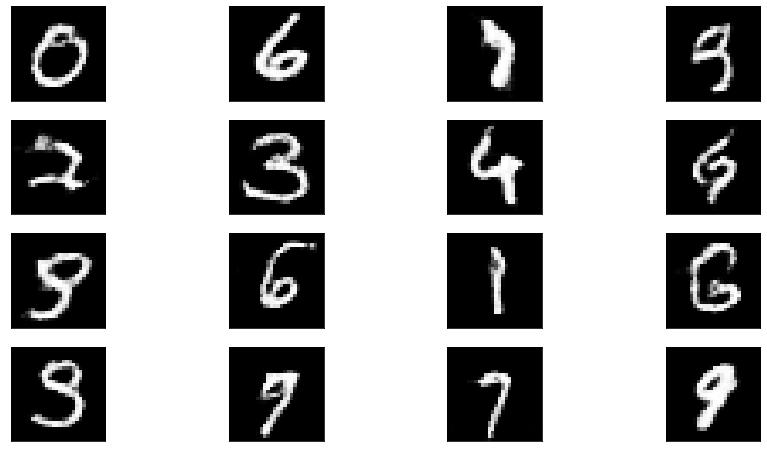

In [190]:
n=16
imgs=gen(torch.randn(n,n_noise,1,1,device=dev)).detach().cpu().squeeze().numpy()
_,axes=plt.subplots(4,4,figsize=(15,8))
for i in range(n):
    ax=axes[i//4,i%4]
    ax.imshow(imgs[i],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)